# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

In [4]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0                      0             5.52   
1                     0                      0             5.52   
2                     1                      0             5.52   
3                     0                      1             5.52   
4                     0                      1             5.52   

   booking_complete  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [6]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
df.describe()

num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         50000.000000          50000.000000           50000.000000   
mean              0.668780              0.296960               0.427140   
std               0.470657              0.456923               0.494668   
min               0.000000              0.000000               0.000000   
25%               0.000000              0.000000               0.000000   
50%               1.000000              0.000000               0.000000   
75%               1.000000              1.000000               1.000000   
max               1.000000              1.000000               1.000000   

       flight_duration  booking_complete  
count     50000.000000      50000.000000  
mean          7.277561          0.149560  
std           1.496863          0.356643  
min           4.670000          0.000000  
25%           5.620000          0.000000  
50%           7.570000          0.000000  
75%           8.830000          0.000000  
max           9.500000          1.000000

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [9]:
# Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [10]:
# Drop rows with missing values (or use .fillna if needed)
df.dropna(inplace=True)



In [11]:
# === Step 2: Prepare Features & Target ===
target_col = 'booking_complete'  # <- Change if needed
X = df.drop(columns=[target_col])
y = df[target_col]

In [12]:
# === Step 3: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# === Step 4: Model Training ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:
# === Step 5: Evaluation ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8562
Precision: 0.571917808219178
Recall: 0.11283783783783784
F1 Score: 0.18848758465011287
ROC AUC: 0.7743073134754472

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.57      0.11      0.19      1480

    accuracy                           0.86     10000
   macro avg       0.72      0.55      0.55     10000
weighted avg       0.82      0.86      0.81     10000



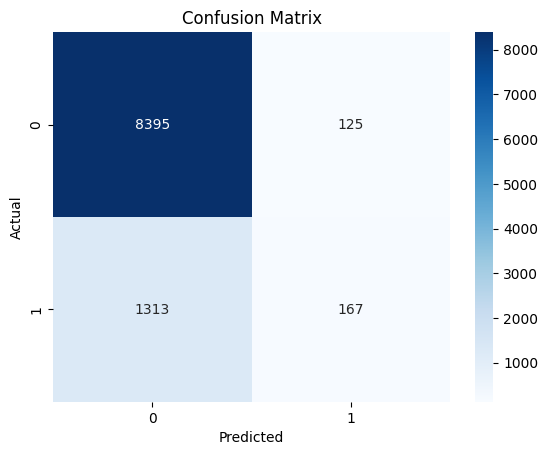

In [16]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

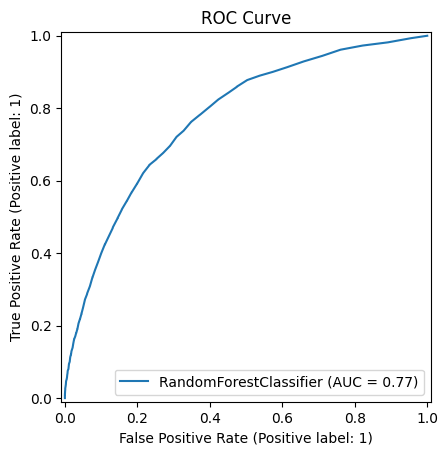

In [17]:
# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

In [18]:
# === Step 6: Feature Importance ===
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_10404\3351132026.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


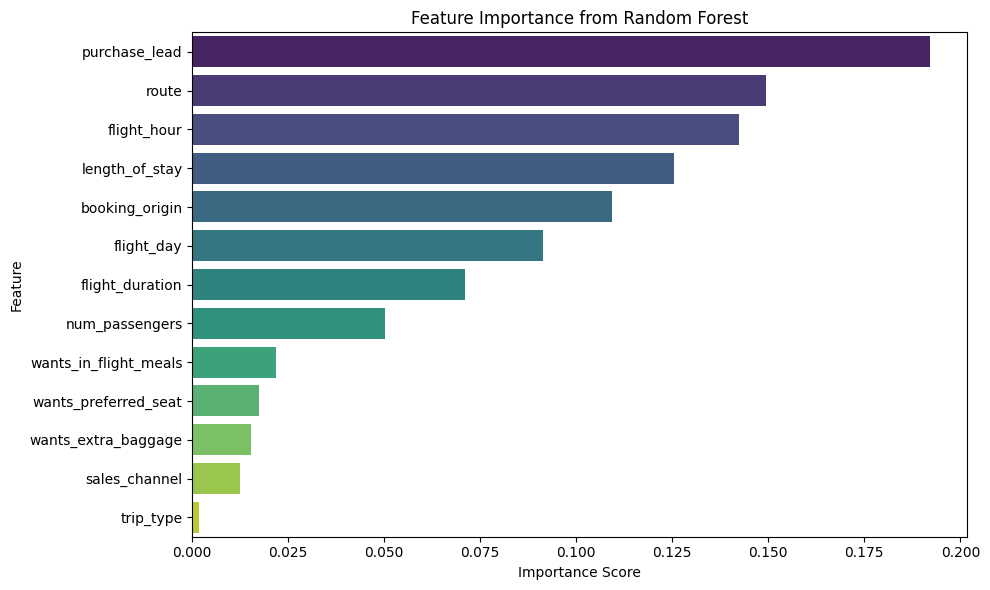

In [19]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [20]:
# === Step 7: Cross-validation Score ===
cv_score = cross_val_score(model, X, y, cv=5, scoring='f1')
print("Cross-validated F1 score (5-fold):", cv_score.mean())

Cross-validated F1 score (5-fold): 0.07859939034260068


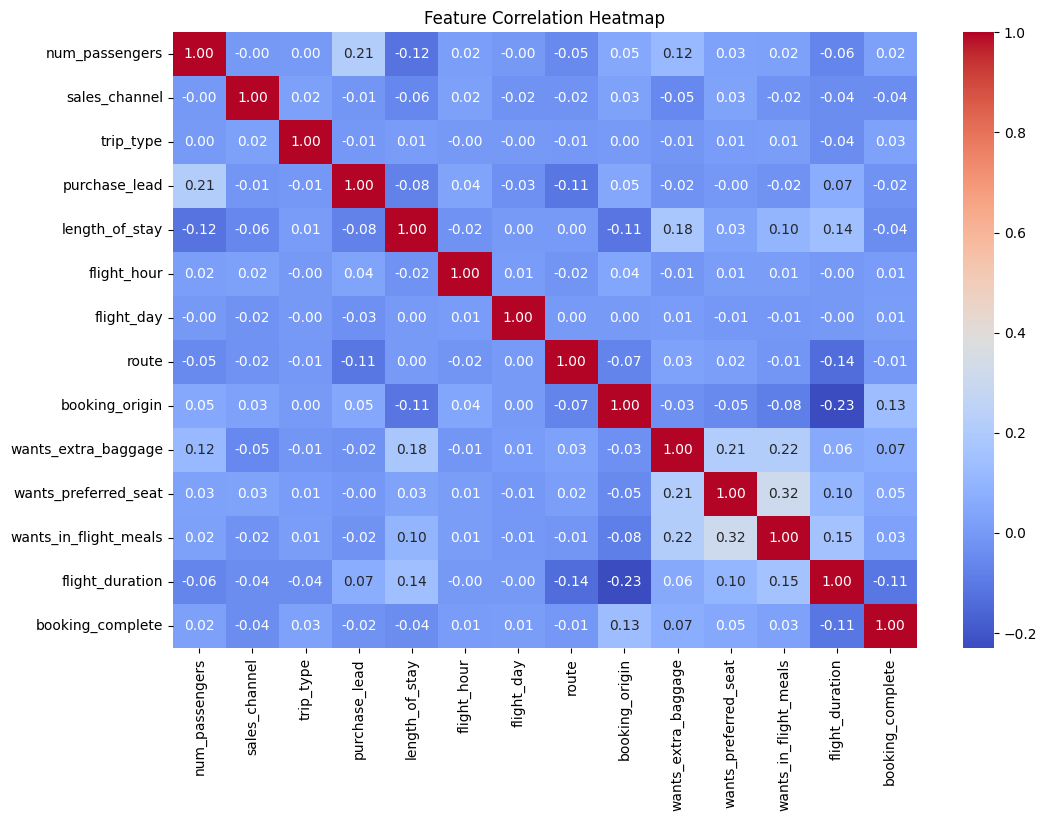

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

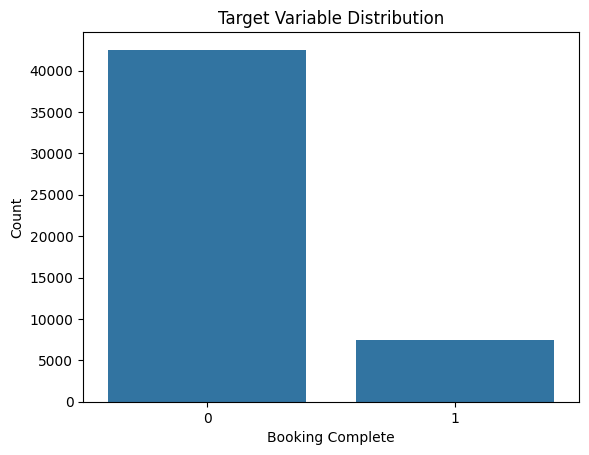

In [22]:
sns.countplot(x='booking_complete', data=df)
plt.title("Target Variable Distribution")
plt.xlabel("Booking Complete")
plt.ylabel("Count")
plt.show()


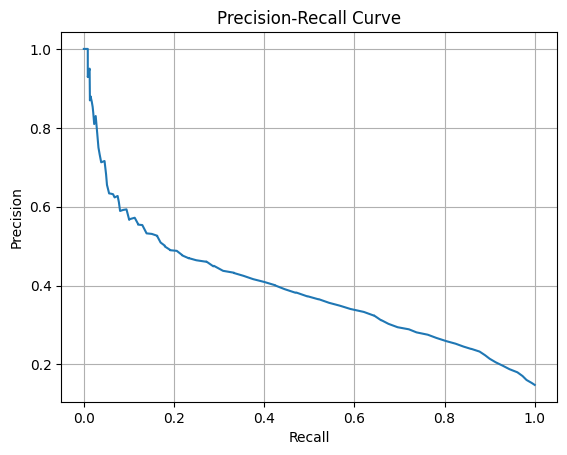

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


In [26]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.